<a href="https://colab.research.google.com/github/MikeIV2007/DS_HW_08/blob/main/DS_HW_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [ ]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer1 = DenseLayer(num_features, n_hidden_1, name="layer1")
    # Другий шар, який складається з 256 нейронів
    self.layer2 = DenseLayer(n_hidden_1, n_hidden_2, name="layer2")
    # Вихідний шар з 10 нейронами (num_classes)
    self.out_layer = DenseLayer(n_hidden_2, num_classes, name="out_layer")

  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.layer1(x, activation=0)
    x = self.layer2(x, activation=0)
    return self.out_layer(x, activation=1)


In [ ]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Перетворення прогнозованих ймовірностей на мітки класів
    y_pred_class = tf.argmax(y_pred, axis=1)
    y_pred_class = tf.cast(y_pred_class, dtype=tf.int32)

    # Порівняння спрогнозованих міток класу з істиннимиy_pred_class = tf.cast(y_pred_class, dtype=tf.int32)
    y_true = tf.cast(y_true, dtype=tf.int32)
    correct_prediction = tf.equal(y_pred_class, y_true)

    # Переведення логічного значення в плаваюче значення та обчислення середнього значення
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy


In [ ]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
    optimizer = tf.optimizers.SGD(learning_rate)
    with tf.GradientTape() as g:
        pred = neural_net(input_x)
        loss = cross_entropy(pred, output_y)

    # Get the list of trainable variables
    trainable_variables = neural_net.trainable_variables

    # Compute gradients
    gradients = g.gradient(loss, trainable_variables)

    # Apply gradients to update parameters
    optimizer.apply_gradients(zip(gradients, trainable_variables))



In [ ]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        loss_history.append(loss)
        accuracy_history.append(acc)
        print(f"Шаг: {step}, Поточна помилка: {loss}, Поточна точність: {acc}")

Шаг: 100, Поточна помилка: 315.5186767578125, Поточна точність: 0.6953125
Шаг: 200, Поточна помилка: 231.4920654296875, Поточна точність: 0.765625
Шаг: 300, Поточна помилка: 167.24496459960938, Поточна точність: 0.8046875
Шаг: 400, Поточна помилка: 182.37355041503906, Поточна точність: 0.82421875
Шаг: 500, Поточна помилка: 129.88055419921875, Поточна точність: 0.85546875
Шаг: 600, Поточна помилка: 114.11891174316406, Поточна точність: 0.875
Шаг: 700, Поточна помилка: 79.13774871826172, Поточна точність: 0.90234375
Шаг: 800, Поточна помилка: 75.77285766601562, Поточна точність: 0.8828125
Шаг: 900, Поточна помилка: 119.50015258789062, Поточна точність: 0.85546875
Шаг: 1000, Поточна помилка: 105.72621154785156, Поточна точність: 0.8671875
Шаг: 1100, Поточна помилка: 166.82907104492188, Поточна точність: 0.8125
Шаг: 1200, Поточна помилка: 117.77395629882812, Поточна точність: 0.86328125
Шаг: 1300, Поточна помилка: 69.69076538085938, Поточна точність: 0.91796875
Шаг: 1400, Поточна помилка: 

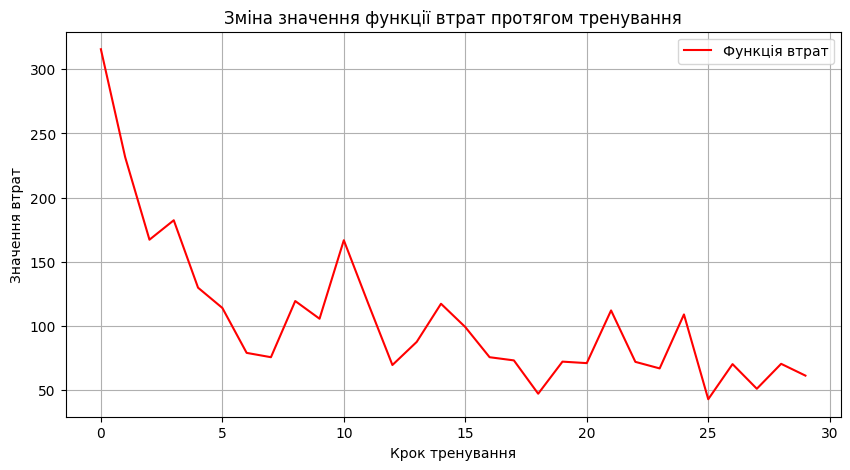

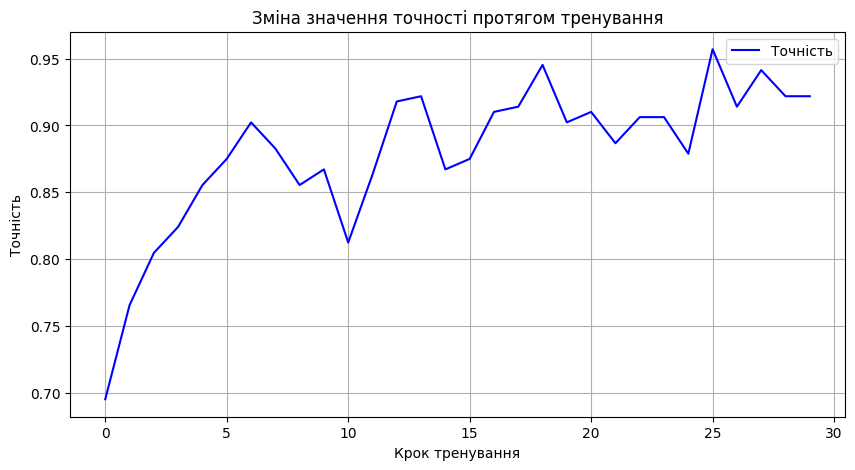

In [ ]:
# Виведіть графік функції втрат
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Функція втрат', color='red')
plt.xlabel('Крок тренування')
plt.ylabel('Значення втрат')
plt.title('Зміна значення функції втрат протягом тренування')
plt.legend()
plt.grid(True)
plt.show()

# Виведіть графік точності
plt.figure(figsize=(10, 5))
plt.plot(accuracy_history, label='Точність', color='blue')
plt.xlabel('Крок тренування')
plt.ylabel('Точність')
plt.title('Зміна значення точності протягом тренування')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Обчисліть точність навченої нейромережі
test_accuracy = accuracy(neural_net(x_test), y_test)
print(f'Точність на тестових даних: {test_accuracy}')

# Тестування моделі на тестових даних
test_loss = cross_entropy(neural_net(x_test), y_test)
print(f'Втрати на тестових даних: {test_loss}')


Точність на тестових даних: 0.9035999774932861
Втрати на тестових даних: 3341.87841796875


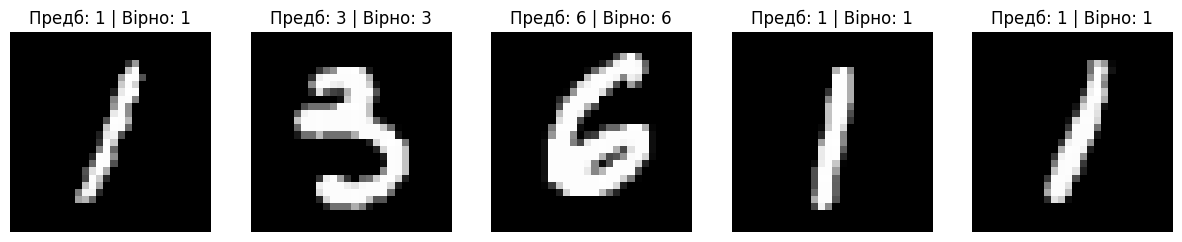

In [ ]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

# Місце для вашого коду
import numpy as np
import matplotlib.pyplot as plt

# Випадковим чином виберемо 5 зображень та їх мітки з тестового набору
random_indices = np.random.choice(len(x_test), 5)
images_to_test = x_test[random_indices]
labels_to_test = y_test[random_indices]

# Отримаємо передбачення для вибраних зображень
predictions = neural_net(images_to_test)
predicted_labels = np.argmax(predictions, axis=1)

# Виведемо зображення та їх передбачені мітки
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images_to_test[i].reshape((28, 28)), cmap='gray')
    plt.title(f'Предб: {predicted_labels[i]} | Вірно: {labels_to_test[i]}')
    plt.axis('off')
plt.show()

Виведіть метрики якості для кожного класу навченої моделі, використовуючи https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

In [ ]:
from sklearn.metrics import classification_report

# Get predictions on test data
y_pred = neural_net(x_test)

# Convert predictions to class labels
y_pred_class = tf.argmax(y_pred, axis=1)

# Generate classification report
report = classification_report(y_test, y_pred_class)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       980
           1       0.98      0.98      0.98      1135
           2       0.89      0.90      0.89      1032
           3       0.87      0.88      0.88      1010
           4       0.89      0.90      0.89       982
           5       0.88      0.84      0.86       892
           6       0.92      0.93      0.93       958
           7       0.91      0.91      0.91      1028
           8       0.84      0.87      0.86       974
           9       0.89      0.87      0.88      1009

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



**Висновок**

Згідно класіфікаційного звіту модель в середньому на 90% дає вірну класіфікацію при роботі з датасетом MNIST.